# Normjam 2019
## Will Townes

The data are hosted at https://github.com/normjam/data . We assume all the AnnData files are downloaded to the data subfolder. Also we assume there is a list of genes to subset on in a CSV file.

Note: unlike rmarkdown this notebook assumes it is being run within its directory rather than from the top-level

In [1]:
!pwd

/Users/townesf/Documents/projects/sc-rna-seq/real/normjam


In [5]:
!wget https://raw.githubusercontent.com/normjam/data/master/genes_1000_pbmc3k.csv -P data

--2019-11-20 12:17:49--  https://raw.githubusercontent.com/normjam/data/master/genes_1000_pbmc3k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11071 (11K) [text/plain]
Saving to: ‘data/genes_1000_pbmc3k.csv’

genes_1000_pbmc3k.c 100%[===================>]  10.81K  --.-KB/s    in 0.001s  

2019-11-20 12:17:49 (16.4 MB/s) - ‘data/genes_1000_pbmc3k.csv’ saved [11071/11071]



In [90]:
import scanpy as sc
import pandas as pd
import time
from glmpca import glmpca
from matplotlib import pyplot as plt
import numpy as np
from scipy import sparse

In [38]:
d = sc.read_h5ad("data/pbmc3k.h5ad")
gg = pd.read_csv("data/genes_1000_pbmc3k.csv",header=-1)
d2 = d[:,gg[1].values]
cm = d2.obs
umis = d2.X.toarray() #make into a dense array
sz = umis.mean(1)

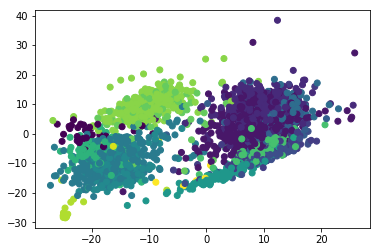

In [59]:
#%%time
fit = glmpca.glmpca(umis.T,2,fam="poi")
#sanity check the result is OK, color code by known cell type IDs
plt.scatter(fit["factors"][:,0],fit["factors"][:,1],c=cm.celltype.cat.codes.values);

In [ ]:
Ls = (2,5,10,30)
#Ls = (2,3) #for testing
fams = ("poi","nb")
res = dict()
tic = time.time()
for f in fams:
    res[f] = dict()
    for L in Ls:
        print("family: {}, num_dims: {}, elapsed: {}".format(f,L,time.time()-tic))
        res[f][L] = glmpca.glmpca(umis.T,L,fam=f)

In [72]:
fit_poi = res["poi"][10]
fit_nb = res["nb"][10]

In [ ]:
nsamples = 50
fit = fit_poi
link = fit["glmpca_family"].family.link
offsets = link(sz)
M = link.inverse(fit['loadings'].dot(fit['factors'].T) + fit['coefX'] + offsets)
ss = np.array([np.random.poisson(M) for j in range(nsamples)]).T
np.savez_compressed("pbmc3k_1kgenes_glmpca10_poi_samples",ss)

In [99]:
nsamples = 50
fit = fit_nb
link = fit["glmpca_family"].family.link
offsets = link(sz)
M = link.inverse(fit['loadings'].dot(fit['factors'].T) + fit['coefX'] + offsets)
r = fit["glmpca_family"].nb_theta
p = r/(r+M)
ss = np.array([np.random.negative_binomial(r,p) for j in range(nsamples)]).T
np.savez_compressed("pbmc3k_1kgenes_glmpca10_nb_samples",ss)

In [112]:
err = ss[:,:,0]-umis
print(np.max(err)) #maximum over-estimate
print(np.min(err)) #max under-estimate
np.sum(err!=0)/np.prod(err.shape) #fraction of data where the prediction was wrong

81.0
-94.0


0.09934656771799628